# Library & Installation

In [7]:
"""
This section installs and loads the required dependencies:
- `transformers` and `sentencepiece` → for HuggingFace summarization models.
- `numpy==1.25.2` → ensures compatibility with scikit-learn and transformers.
Then, it imports all required libraries for:
- Text preprocessing (re, nltk, BeautifulSoup)
- Summarization (transformers)
- Data handling and visualization (pandas, seaborn, matplotlib, tqdm)
- Text analysis (Counter, WordCloud, stopwords)
"""

!pip install transformers sentencepiece -q
!pip install numpy==1.25.2 -q
!pip install wordcloud -q

import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline, logging
from wordcloud import WordCloud
import nltk

# Silence warnings and set display options
warnings.filterwarnings("ignore")
logging.set_verbosity_error()
pd.set_option('display.max_colwidth', None)
tqdm.pandas(desc="Summarizing", dynamic_ncols=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Overview

In [8]:
"""
Reads the CSV file containing Superman movie reviews.
The file is loaded into a pandas DataFrame and the first 5 rows
are displayed to verify that the data has been scraped & loaded correctly.
"""

df = pd.read_csv("/kaggle/input/superman-movie-reviews/Superman_reviews.csv")
df.head()

review
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Boring, Shallow, Predictable I am a fan of superhero movies but this is definitely one of the worst I've ever seen. I had really high hopes for it but it did not deliver. I admit it is visually goo

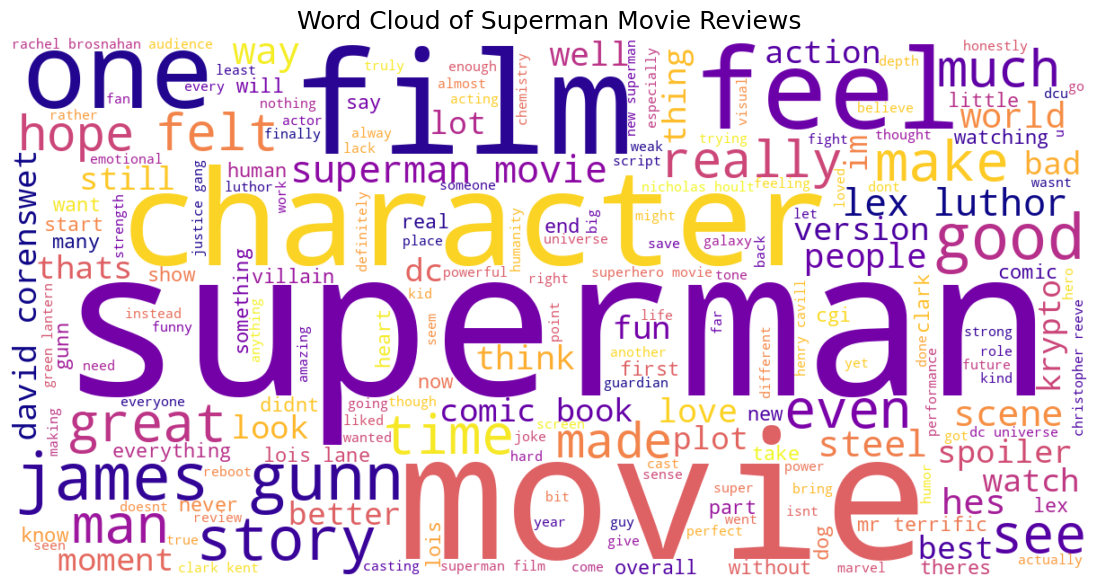

In [17]:
"""
This section generates a Word Cloud visualization of the Superman movie reviews to 
provide an intuitive overview of the most commonly used words in Superman reviews,
highlighting key themes and sentiments based on word frequency.
"""

# --- Word Cloud Visualization ---
token = " ".join(str(review) for review in df['review'].dropna())
token = re.sub(r'[^A-Za-z ]+', '', token.lower())
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='plasma', max_words=200).generate(token)

plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Superman Movie Reviews", fontsize=18)
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


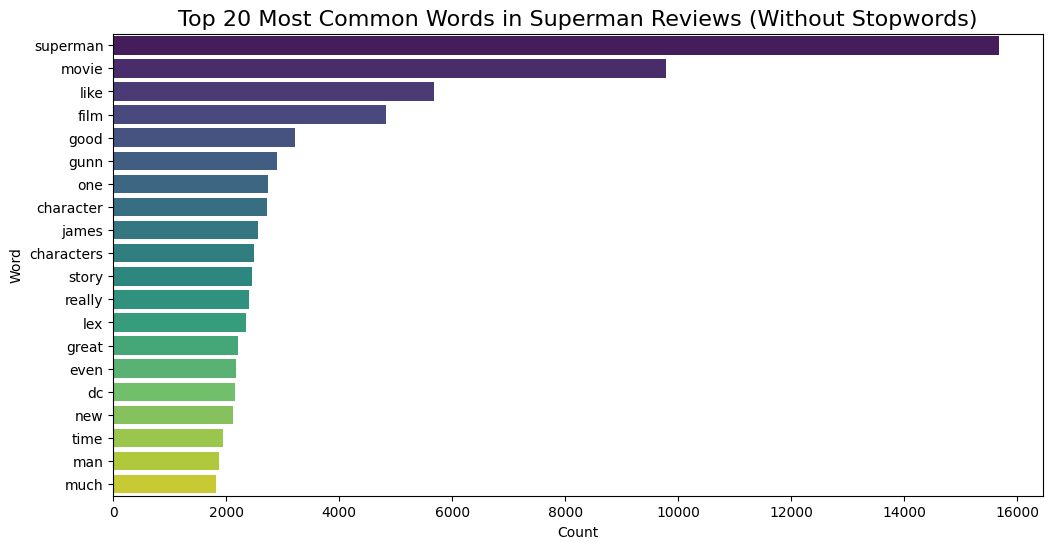

In [19]:
"""
This section visualizes the top 20 most frequent words in the Superman movie reviews
after removing common English stopwords to identify and display the most frequently used meaningful 
words in the Superman reviews, helping to uncover recurring themes or topics mentioned by viewers.
"""

# --- Top 20 Frequent Words Visualization ---
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

words = [w.lower() for w in text.split() if w.lower() not in stop_words and w.isalpha()]
word_freq = Counter(words)
common_words = word_freq.most_common(20)
word_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12,6))
sns.barplot(data=word_df, x='count', y='word', palette='viridis')
plt.title("Top 20 Most Common Words in Superman Reviews (Without Stopwords)", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

# Preprocessing

In [9]:
"""
This section sets up multiple Hugging Face summarization models and defines preprocessing,
cleaning, and safe application functions for summarizing text data.

Models initialized:
- T5 (t5-small) → Lightweight text-to-text transformer for general summarization.
- BART (facebook/bart-large-cnn) → Strong baseline for summarizing news and long text.
- PEGASUS (google/pegasus-cnn_dailymail) → Specialized in abstractive summarization of news-style text.
- LED (allenai/led-base-16384) → Handles long documents efficiently with extended context length.

Additional components:
1. Lemmatizer:
   - Uses NLTK’s `WordNetLemmatizer` to reduce words to their base forms for cleaner input.
2. Contraction Mapping:
   - A dictionary that expands English contractions (e.g., “don’t” → “do not”) 
     to improve model understanding and maintain consistent text representation.
3. Text Cleaning Function (`text_cleaner`):
   - Converts text to lowercase and removes:
     - HTML tags (`BeautifulSoup`)
     - Parentheses and punctuation
     - Contractions using the predefined mapping
     - Non-alphabetic characters
   - Performs lemmatization and filters out very short tokens.
   - Returns a clean, normalized version of the review text.
4. Safe Summarizer Wrapper (`make_safe_summarizer`):
   - Wraps each model to handle short or empty inputs safely.
   - Cleans text before summarization.
   - Sets default parameters:
     - `max_new_tokens`: 50
     - `truncation`: True
     - `do_sample`: False (for deterministic output)
5. Model Application Methods:
   - Defines custom `pandas.Series` methods:
     - `T5_apply()`
     - `BART_apply()`
     - `PEGASUS_apply()`
     - `LED_apply()`
   - Each applies its respective summarization model using `tqdm.progress_apply`
     for progress tracking during summarization.

Purpose:
To provide a robust, reusable framework for cleaning and summarizing movie reviews
using four state-of-the-art transformer-based models, enabling performance comparison
across different summarization architectures.
"""

T5_model = pipeline("summarization", model="t5-small", tokenizer="t5-small", device=-1) 
BART_model = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer="facebook/bart-large-cnn", device=-1)
PEGASUS_model = pipeline("summarization", model="google/pegasus-cnn_dailymail", tokenizer="google/pegasus-cnn_dailymail", device=-1)
LED_model = pipeline("summarization", model="allenai/led-base-16384", tokenizer="allenai/led-base-16384", device=-1)

# --- lemmatizer ---
lemmatizer = WordNetLemmatizer()

# --- Contraction mapping ---
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                       "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock","oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                       "they're": "they are", "they've": "they have", "to've": "to have","wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are","we've": "we have", 
                       "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have","would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                       "you'll": "you will", "you'll've": "you will have","you're": "you are", "you've": "you have"}

def text_cleaner(text, num=0):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split()])
    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    
    tokens = newString.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens = [w for w in tokens if len(w) > 1]
    
    return " ".join(tokens).strip()

def make_safe_summarizer(model, max_len=50):
    def summarizer(text):
        text = text_cleaner(str(text))
        
        if len(text.split()) < 5:
            return text
        
        return model(text, max_new_tokens=max_len, truncation=True, do_sample=False)[0]['summary_text']
    return summarizer

def T5_apply(self, func=None):
    if func is None:
        func = make_safe_summarizer(T5_model)
    return self.progress_apply(func)

def BART_apply(self, func=None):
    if func is None:
        func = make_safe_summarizer(BART_model)
    return self.progress_apply(func)

def PEGASUS_apply(self, func=None):
    if func is None:
        func = make_safe_summarizer(PEGASUS_model)
    return self.progress_apply(func)

def LED_apply(self, func=None):
    if func is None:
        func = make_safe_summarizer(LED_model)
    return self.progress_apply(func)

pd.Series.T5_apply = T5_apply
pd.Series.BART_apply = BART_apply
pd.Series.PEGASUS_apply = PEGASUS_apply
pd.Series.LED_apply = LED_apply

# Modeling

In [10]:
"""
This section performs text summarization using four different pre-trained transformer models 
on a random subset of 100 movie reviews from the dataset.

Steps performed:
1. Sampling:
   - Randomly selects 100 reviews from the full dataset (`df`) using `random_state=42` 
     to ensure reproducibility.
   - The sampled data is stored in a new DataFrame called `df_sample`.

2. Summarization:
   - Applies four different summarization pipelines defined earlier:
     - `T5_apply()` → Uses the T5 model (`t5-small`).
     - `BART_apply()` → Uses the BART model (`facebook/bart-large-cnn`).
     - `PEGASUS_apply()` → Uses the PEGASUS model (`google/pegasus-cnn_dailymail`).
     - `LED_apply()` → Uses the Longformer Encoder-Decoder model (`allenai/led-base-16384`).
   - Each method processes the “review” column, cleans the text, and generates a concise summary.

3. Result:
   - Four new columns (`summary_T5`, `summary_BART`, `summary_PEGASUS`, `summary_LED`) 
     are added to `df_sample`, each containing summaries generated by the respective model.

Purpose:
To compare the summarization quality and style of different transformer-based models 
on the same review samples, allowing for performance or readability evaluation.
"""

df_sample = df.sample(n=100, random_state=42).copy()

df_sample['summary_T5'] = df_sample['review'].T5_apply()

Summarizing: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


In [11]:
df_sample['summary_BART'] = df_sample['review'].BART_apply()

Summarizing: 100%|██████████| 100/100 [10:22<00:00,  6.22s/it]


In [12]:
df_sample['summary_PEGASUS'] = df_sample['review'].PEGASUS_apply()

Summarizing: 100%|██████████| 100/100 [14:16<00:00,  8.56s/it]


In [13]:
df_sample['summary_LED'] = df_sample['review'].LED_apply()

Summarizing: 100%|██████████| 100/100 [06:56<00:00,  4.17s/it]


# Qualitative Analysis & Data Export

In [14]:
"""
# Qualitative Analysis & Data Export

This section performs a qualitative examination of the summarization results 
and exports the summarized dataset for external analysis.

Steps performed:
1. Qualitative Review:
   - Displays the first few rows of `df_sample` to manually inspect and compare:
     - The original movie review text.
     - The cleaned review (after preprocessing).
     - Summaries generated by the four transformer models (T5, BART, PEGASUS, LED).
   - This allows direct observation of differences in summarization quality, 
     abstraction level, and content retention.

2. Qualitative Analysis Summary:
   - A manual evaluation was conducted on sample reviews to assess the summarization quality.
   - Key findings:
     - PEGASUS produced the most natural and fluent summaries, capturing tone and readability best.  
     - BART provided structured and detailed summaries with strong content retention.  
     - T5 offered concise abstractions but tended to oversimplify the original text.  
     - LED retained the highest detail level, yet often became too verbose for shorter reviews.
   - Overall, PEGASUS is most suitable for human-readable summaries, while BART excels for analytical contexts requiring more detail.

3. Data Export:
   - Saves the summarized dataset into a CSV file named **`Superman_review_summarized.csv`**.
   - File includes the following columns:
     - `review` → original user review text.
     - `summary_T5`, `summary_BART`, `summary_PEGASUS`, `summary_LED` → 
       summaries generated by each respective model.
   - File is encoded in UTF-8 to ensure compatibility across platforms and text editors.

Purpose:
To enable qualitative comparison and external evaluation of summarization models 
on real movie reviews, and to preserve results for further experimentation, 
analysis, or reporting.
"""

df_sample.head()

review  \
2392                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [16]:
df_sample.to_csv("Superman_review_summarized.csv", index=False, encoding="utf-8")